In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# Students will submit their files with their team-name.py
# Student have to use the Team as their parent class

Recent Version of the Code

In [272]:
class ROLLNUMBER_Q4:
  def __init__(self,num_balls,num_matches, version=1):
    self.num_arms = 6
    self.num_balls = num_balls
    self.num_matches = num_matches
    self.round = 0
    self.wickets = np.zeros(self.num_arms)
    self.occur = np.zeros(self.num_arms)
    self.runs = np.zeros(self.num_arms)
    self.a = np.ones(self.num_arms)
    self.b = np.ones(self.num_arms)
    self.prev_action = 0
    self.epsilon = 1e-8
    self.ub = 1e-4
    self._hmap = np.array([1,1,2,3,4,6])
    self.hmap = np.array([0,1,2,3,4,6])
    self.version = version
    self.a = np.ones(self.num_arms)
    self.b = np.ones(self.num_arms)
    self.a_w = np.ones(self.num_arms)
    self.b_w = np.ones(self.num_arms)

  @staticmethod
  def kl_div(p, q):
    if q==0 and p==0:
        return 0
    if q==0 and p!=0:
        return pow(10, 10)
    if q==1 and p==1:
        return 0
    if q==1 and p!=1:
        return pow(10, 10)
    if p==0:
        return np.log(1/(1-q))
    if p==1:
        return np.log(1/q)
    
    return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

  def kl_conf(self, t, em, num_pulls, precision=1e-6, max_iter=100):
    n = 0
    lower_bound = em
    upper_bound = 1
    
    while n<max_iter and (upper_bound-lower_bound)>precision:
        q = (lower_bound + upper_bound)/2
        if self.kl_div(em, q) < np.log(1+t*np.log(t)**2)/num_pulls:
            upper_bound = q
        else:
            lower_bound = q
        n += 1
        
    return (upper_bound+lower_bound)/2
    
  def get_action(self,wicket,runs_scored):
    X = wicket
    R = runs_scored
    
    if self.round>0:
        self.runs[self.prev_action] += R
        self.wickets[self.prev_action] += X
        self.a_w[self.prev_action] += X
        self.b_w[self.prev_action] += 1-X
        self.occur[self.prev_action] += 1
        if X==1:
            self.b[self.prev_action] += 1
        else:
            if (R==self.prev_action) or (R==6 and self.prev_action==5):
                self.a[self.prev_action] += 1
            else:
                self.b[self.prev_action] += 1
    
    if self.round < 6:
        action = self.round
        
    else:
        if self.version == 1:
            kl_conf_num = np.array([self.kl_conf(self.round, (self.runs[idx]/self._hmap[idx])/self.occur[idx], self.occur[idx]) for idx in range(self.num_arms)])
            kl_conf_den = np.array([self.kl_conf(self.round, 1-self.wickets[idx]/self.occur[idx], self.occur[idx]) for idx in range(self.num_arms)])
            action = np.argmax(kl_conf_num*self.hmap/(1-kl_conf_den+self.epsilon)*self.runs/self.occur)
        elif self.version==0:
            kl_conf = np.array([self.kl_conf(self.round, (self.runs[idx]/self._hmap[idx])/(self.wickets[idx]+self.epsilon)*self.ub, self.occur[idx]) for idx in range(self.num_arms)])
            action = np.argmax(kl_conf*self.hmap*self.runs/self.occur)
        else:
            thompson = np.random.beta(self.a, self.b)*self.hmap/np.random.beta(self.a_w, self.b_w)
            action = np.argmax(thompson)
                       
        
    self.prev_action = action
    self.round += 1

    return action



In [273]:
class Environment:
  def __init__(self,num_balls,agent):
    self.num_balls = num_balls
    self.agent = agent
    self.__run_time = 0
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__runs_scored = 0
    self.__start_time = 0
    self.__end_time = 0
    self.__p_out =np.array([0.001,0.01,0.02,0.03,0.1,0.3])
    self.__p_run =np.array([1,0.9,0.85,0.7,0.75,0.7])
    self.__action_runs_map = np.array([0,1,2,3,4,6])
    self.__wickets_left = 4
    self.__wicket = 0
    self.__runs_scored = 0
    self.__start_time = 0
    self.__end_time = 0
    self.__batting_order = np.array([0,1,2,3])

  def __get_action(self):
    self.__start_time      = time. time()
    action          = self.agent.get_action(self.__wicket, self.__runs_scored)
    self.__end_time        = time. time()
    self.__run_time   = self.__run_time + self.__end_time - self.__start_time
    return action


  def __get_outcome(self, action):
    pout = self.__p_out[action]
    prun = self.__p_run[action]
    wicket = np.random.choice(2,1,p=[1-pout,pout])[0]
    runs = 0
    if(wicket==0):
      runs = self.__action_runs_map[action]*np.random.choice(2,1,p=[1-prun,prun])[0]
    return wicket, runs


  def innings(self):
    self.__wickets_left = 4
    self.__runs_scored = 0
    self.__wickets_left = 4
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__run_time = 0
    self.__start_time = 0
    self.__end_time = 0

    for ball in range(self.num_balls):
      if (self.__wickets_left > 0 ) :
        action = self.__get_action()
        self.__wicket, self.__runs_scored   = self.__get_outcome(action)
        self.__total_runs     = self.__total_runs + self.__runs_scored
        if (self.__wicket > 0 ):
          self.__wickets_left = self.__wickets_left -1
        self.__total_wickets  = self.__total_wickets + self.__wicket
        if (self.__wickets_left == 0):
          self.__get_action()
    return self.__total_runs, self.__total_wickets, self.__run_time


In [315]:
num_matches = 10
num_balls = 1000
agent = ROLLNUMBER_Q4(num_balls,num_matches, version=3)
environment = Environment(num_balls, agent)
score = np.zeros((num_matches,1))
run_time = np.zeros((num_matches,1))
wicket = np.zeros((num_matches,1))
for i in range(num_matches):
  score[i],wicket[i],run_time[i] = environment.innings()


In [316]:
print(f'Total Score after {num_matches} is : {np.sum(score)}')

Total Score after 10 is : 2640.0


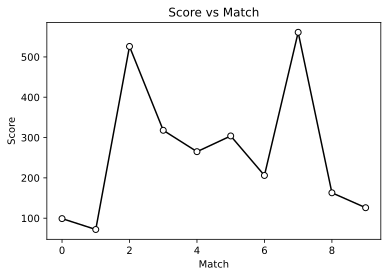

In [317]:
plt.plot(range(num_matches), score, marker='o', color='black', markerfacecolor='white')
plt.xlabel('Match')
plt.ylabel("Score")
plt.title("Score vs Match")
plt.show()

In [318]:
agent2 = ROLLNUMBER_Q4(num_balls,num_matches, version=0)
environment = Environment(num_balls, agent2)
score = np.zeros((num_matches,1))
run_time = np.zeros((num_matches,1))
wicket = np.zeros((num_matches,1))
for i in range(num_matches):
  score[i],wicket[i],run_time[i] = environment.innings()

In [319]:
print(f'Total Score after {num_matches} is : {np.sum(score)}')

Total Score after 10 is : 2493.0


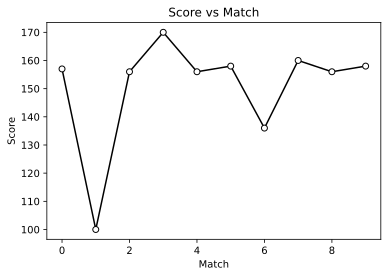

In [263]:
plt.plot(range(num_matches), score, marker='o', color='black', markerfacecolor='white')
plt.xlabel('Match')
plt.ylabel("Score")
plt.title("Score vs Match")
plt.show()

In [133]:
agent.occur

array([  1., 104., 855.,  21.,  17.,   1.])

In [82]:
agent2.occur

array([1.000e+00, 3.100e+01, 5.200e+01, 8.958e+03, 1.000e+00, 1.000e+00])

In [84]:
p_out =np.array([0.001,0.01,0.02,0.03,0.1,0.3])
p_run =np.array([1,0.9,0.85,0.7,0.75,0.7])
action_runs_map = np.array([0,1,2,3,4,6])

(1-p_out)*(p_run)*action_runs_map/(p_out)

array([ 0. , 89.1, 83.3, 67.9, 27. ,  9.8])

In [136]:
p_out_agent = agent.wickets/agent.occur

In [137]:
p_num_agent = agent.runs/agent._hmap/agent.occur

In [138]:
p_out_agent

array([0.        , 0.02702703, 0.03571429, 0.03213028, 0.33333333,
       0.25      ])

In [139]:
p_num_agent

array([0.        , 0.86486486, 0.82142857, 0.77354754, 0.66666667,
       0.75      ])